In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
changed = False
if not changed:
    os.chdir("..")
    changed = True
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee

In [2]:
config_path = "configs/configs_drosophila"
temp_results_path = "temp_results/drosophila"  
results_path = "results_csvs/drosophila"
apply_thresh = True


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]



h5_folder = f"{submission_folder}/h5_files"

In [5]:
ds = dtds.dsFromFile(data_file)
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading Drosophila


In [6]:
samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


thresh: -1919.9684391619867


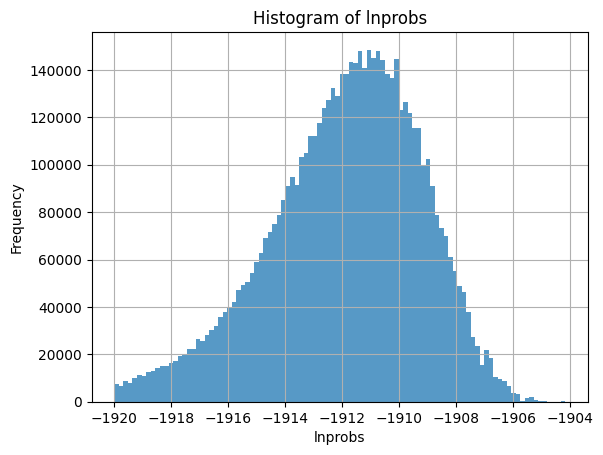

In [7]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 20)
print(f"thresh: {thresh}")

plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [8]:
if apply_thresh:
    samples_trans = samples_trans0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

In [9]:
sorted_samples_trans = samples_trans[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
p1,p2,p3,p4 = srmc.get_params_from_thetas(sorted_samples_trans)
medians_trans = [np.median(p1),np.median(p2),np.median(p3),np.median(p4)]
means_trans = [np.mean(p1),np.mean(p2),np.mean(p3),np.mean(p4)]
stds_trans = [np.std(p1),np.std(p2),np.std(p3),np.std(p4)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev_trans = [median_abs_deviation(p1),median_abs_deviation(p2),median_abs_deviation(p3),median_abs_deviation(p4)]

In [10]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

In [11]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
etas,betas,epsilons,xcs = srmc.get_params_from_thetas(sorted_samples)
medians = [np.median(etas),np.median(betas),np.median(epsilons),np.median(xcs)]
means = [np.mean(etas),np.mean(betas),np.mean(epsilons),np.mean(xcs)]
stds = [np.std(etas),np.std(betas),np.std(epsilons),np.std(xcs)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev = [median_abs_deviation(etas),median_abs_deviation(betas),median_abs_deviation(epsilons),median_abs_deviation(xcs)]



(16,)


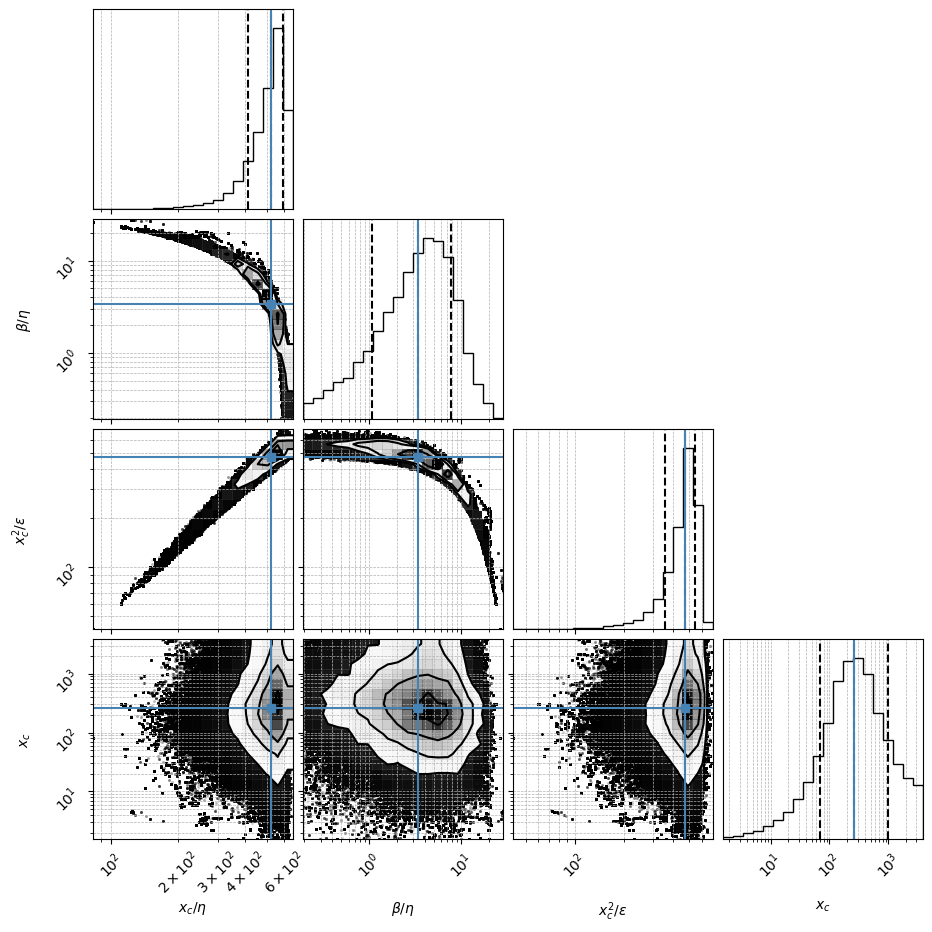

In [12]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians_trans)
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

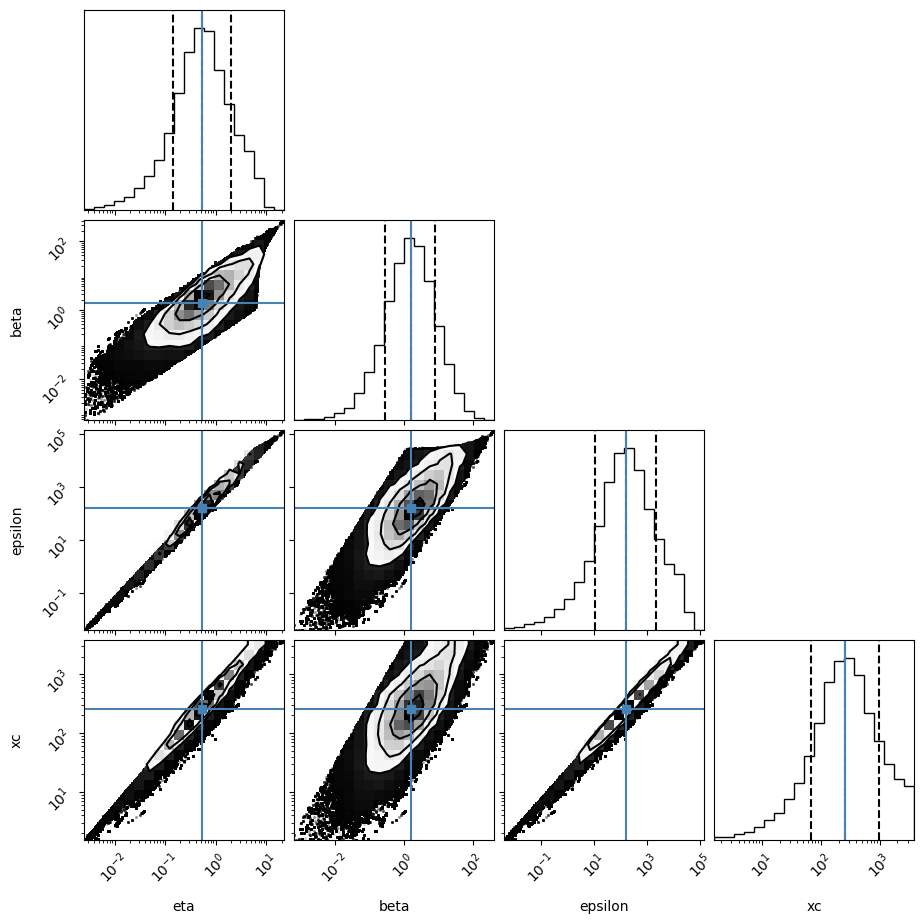

In [13]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians)

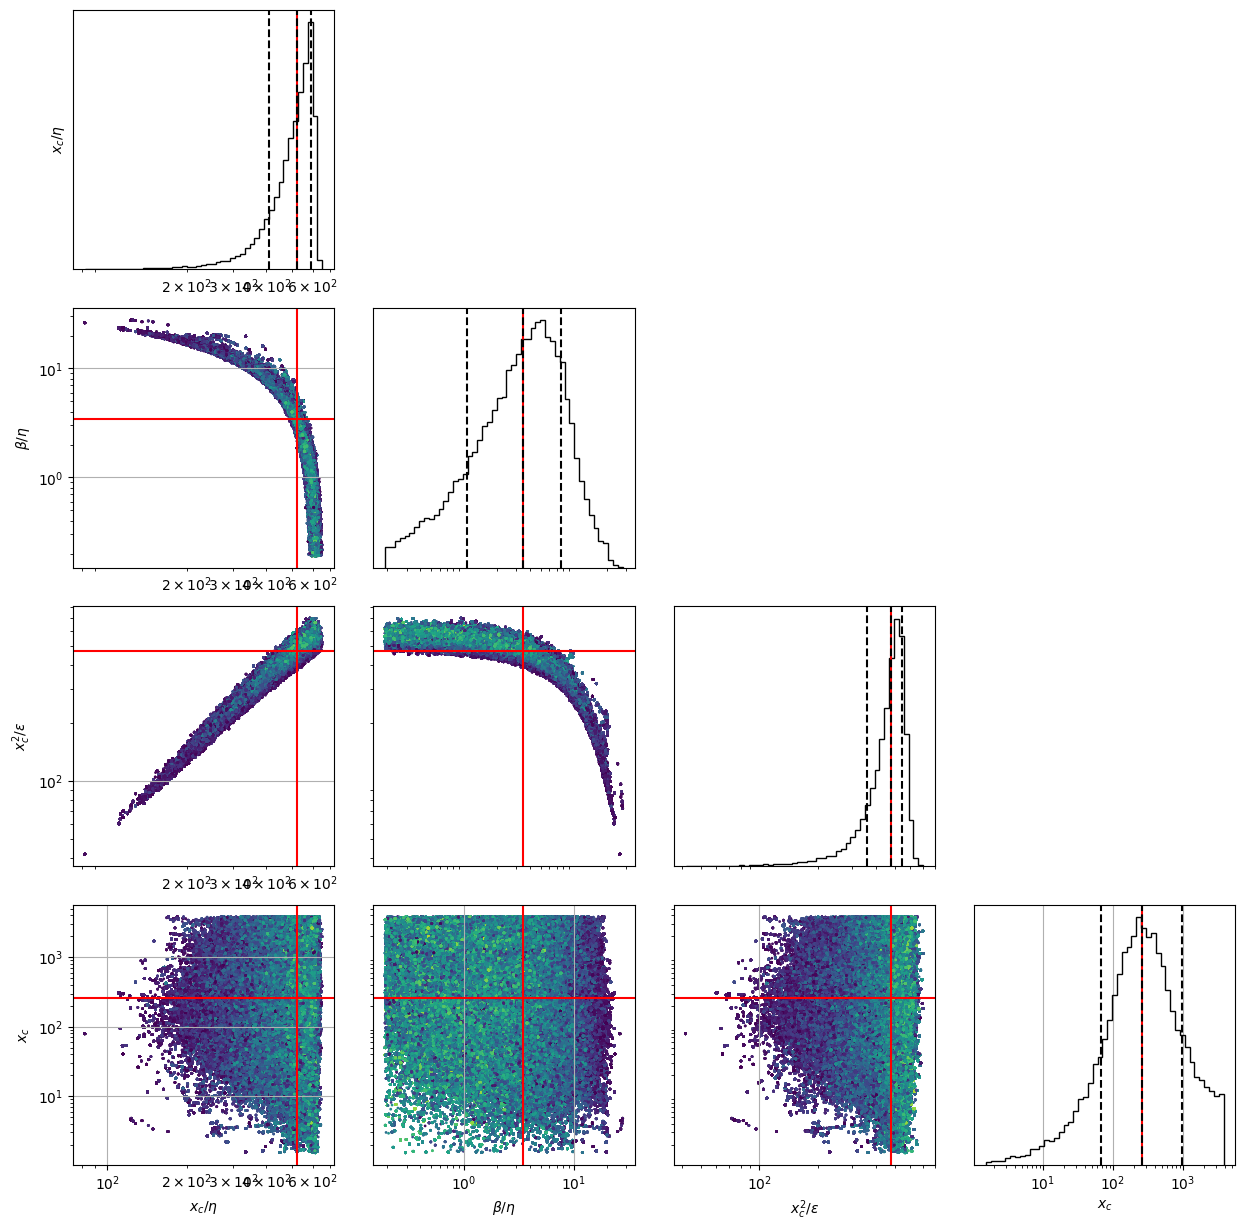

In [14]:
fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= medians_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"])

In [15]:

fact=1
import boltsman_stats as bs
dfb = bs.get_stats(samples, lnprobs,ds, file_path=temp_results_path,percent=False)

                            Eta   Beta  Epsilon      Xc  Beta/Eta  Beta*Xc/Eps  Fx=Beta^2/(Eta*Xc)  Dx=Beta*Eps/(Eta*Xc^2)  Xc^2/Eps  Beta*Kappa/Eps  Fk=Beta^2/(Eta*Kappa)  Dk=Beta*Eps/(Eta*Kappa^2)  s=(Xc^1.5*Eta^0.5)/Eps  Slope=Eta*Xc/Eps  Xc/Eps   Fk/Dk  Fk^2/Dk  t_eta  Median Lifetime
Best fit                   0.33   0.33    69.09  194.58      1.02         0.93              0.0017                  0.0019    547.97          0.0024                   0.67                     280.65                   22.42             0.920    2.82  0.0024   0.0016  24.44            32.00
Median                     0.53   1.60   154.15  259.37      3.42         3.13              0.0220                  0.0072    474.71          0.0054                  10.49                    1841.36                   20.62             0.900    1.68  0.0054   0.0700  22.86            32.00
Mean                       1.10   5.21  1843.13  538.55      4.38         3.79              0.1000                  0.0140    453.

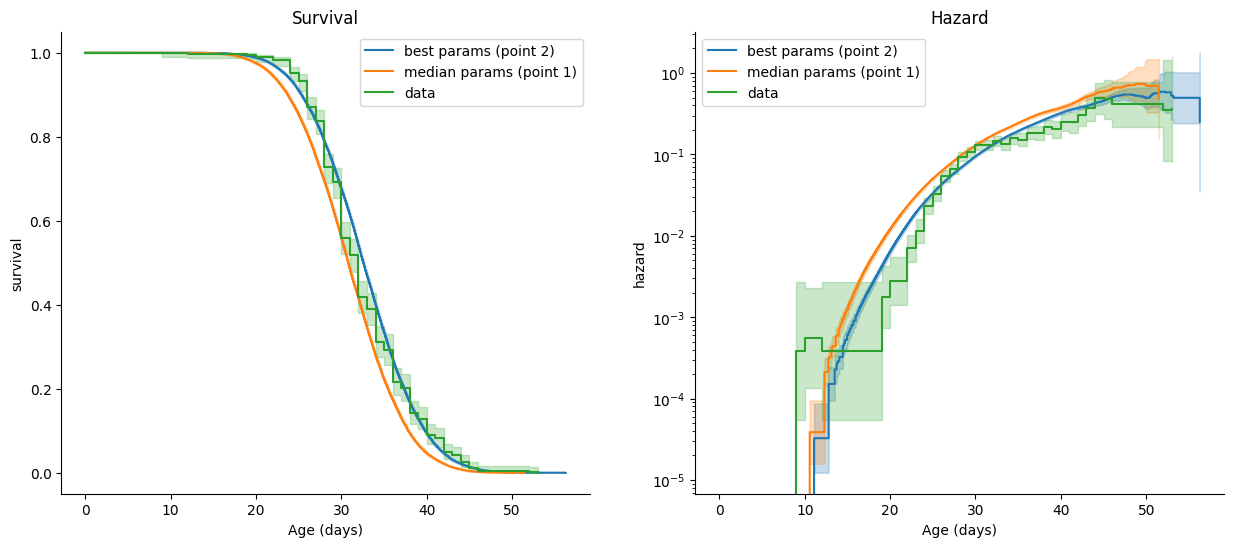

In [12]:
best_theta = sorted_samples[-1]

best_sim = srmc.getSr(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)


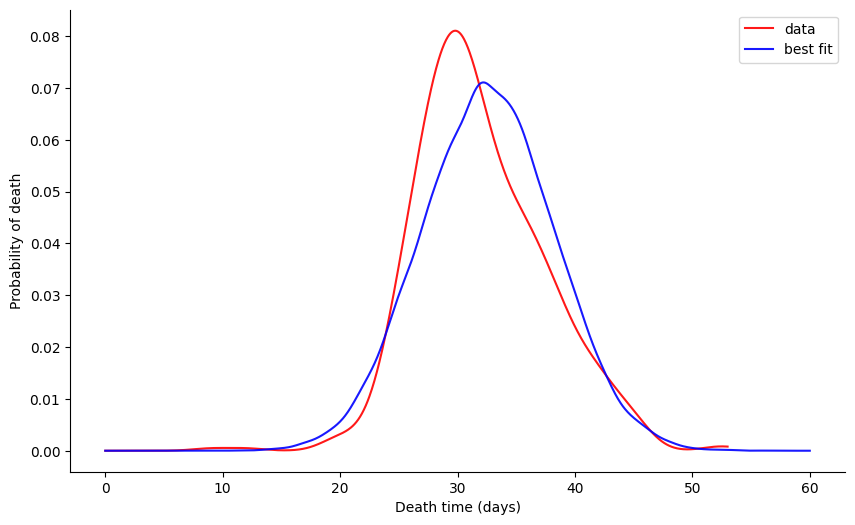

In [13]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
ds.plotDeathTimesDistribution(ax=ax,use_kde=True, label='data', color='r',alpha=0.9)
best_sim.plotDeathTimesDistribution(ax=ax,use_kde=True, label='best fit', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 124424/124424 [00:00<00:00, 405345.72it/s]


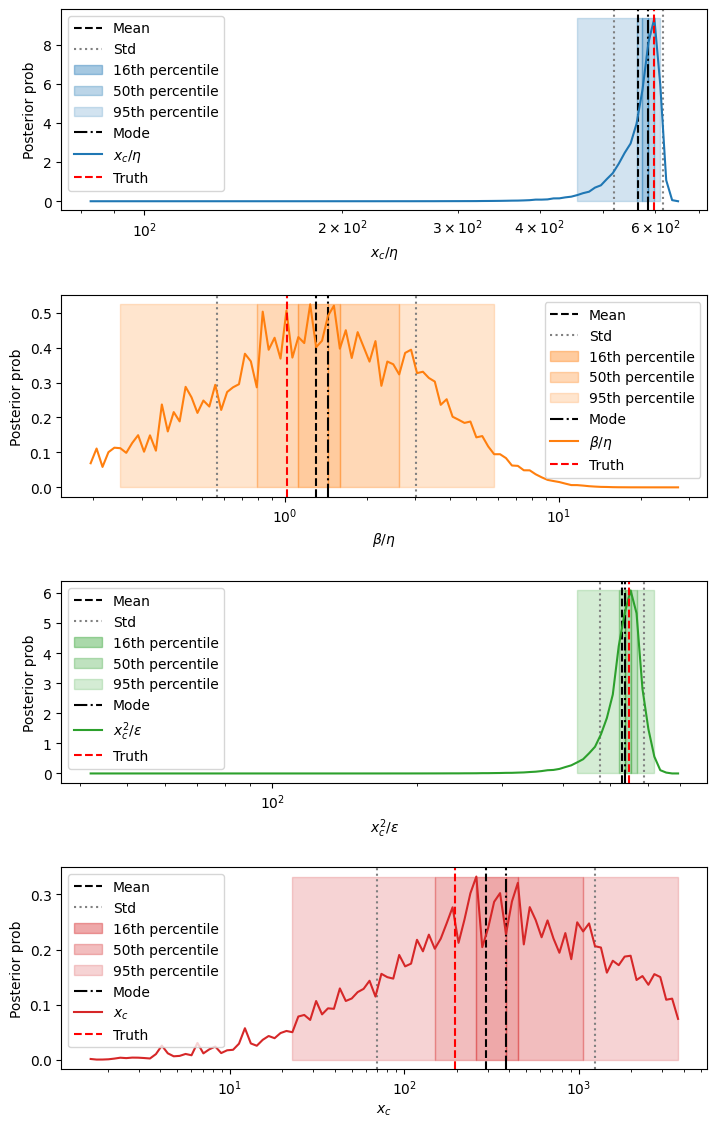

In [14]:
import samples_utils as su
post = su.Posterior(samples_trans, lnprobs, 100, log=True)
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log')

Creating corner plot: 100%|██████████| 4/4 [01:22<00:00, 20.63s/it]


array([[<Axes: xlabel='$x_c/\\eta$', ylabel='Posterior prob'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$\\beta/\\eta$'>,
        <Axes: xlabel='$\\beta/\\eta$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: xlabel='$x_c^2/\\epsilon$', ylabel='Posterior prob'>,
        <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$x_c^2/\\epsilon$', ylabel='$x_c$'>,
        <Axes: xlabel='$x_c$', ylabel='Posterior prob'>]], dtype=object)

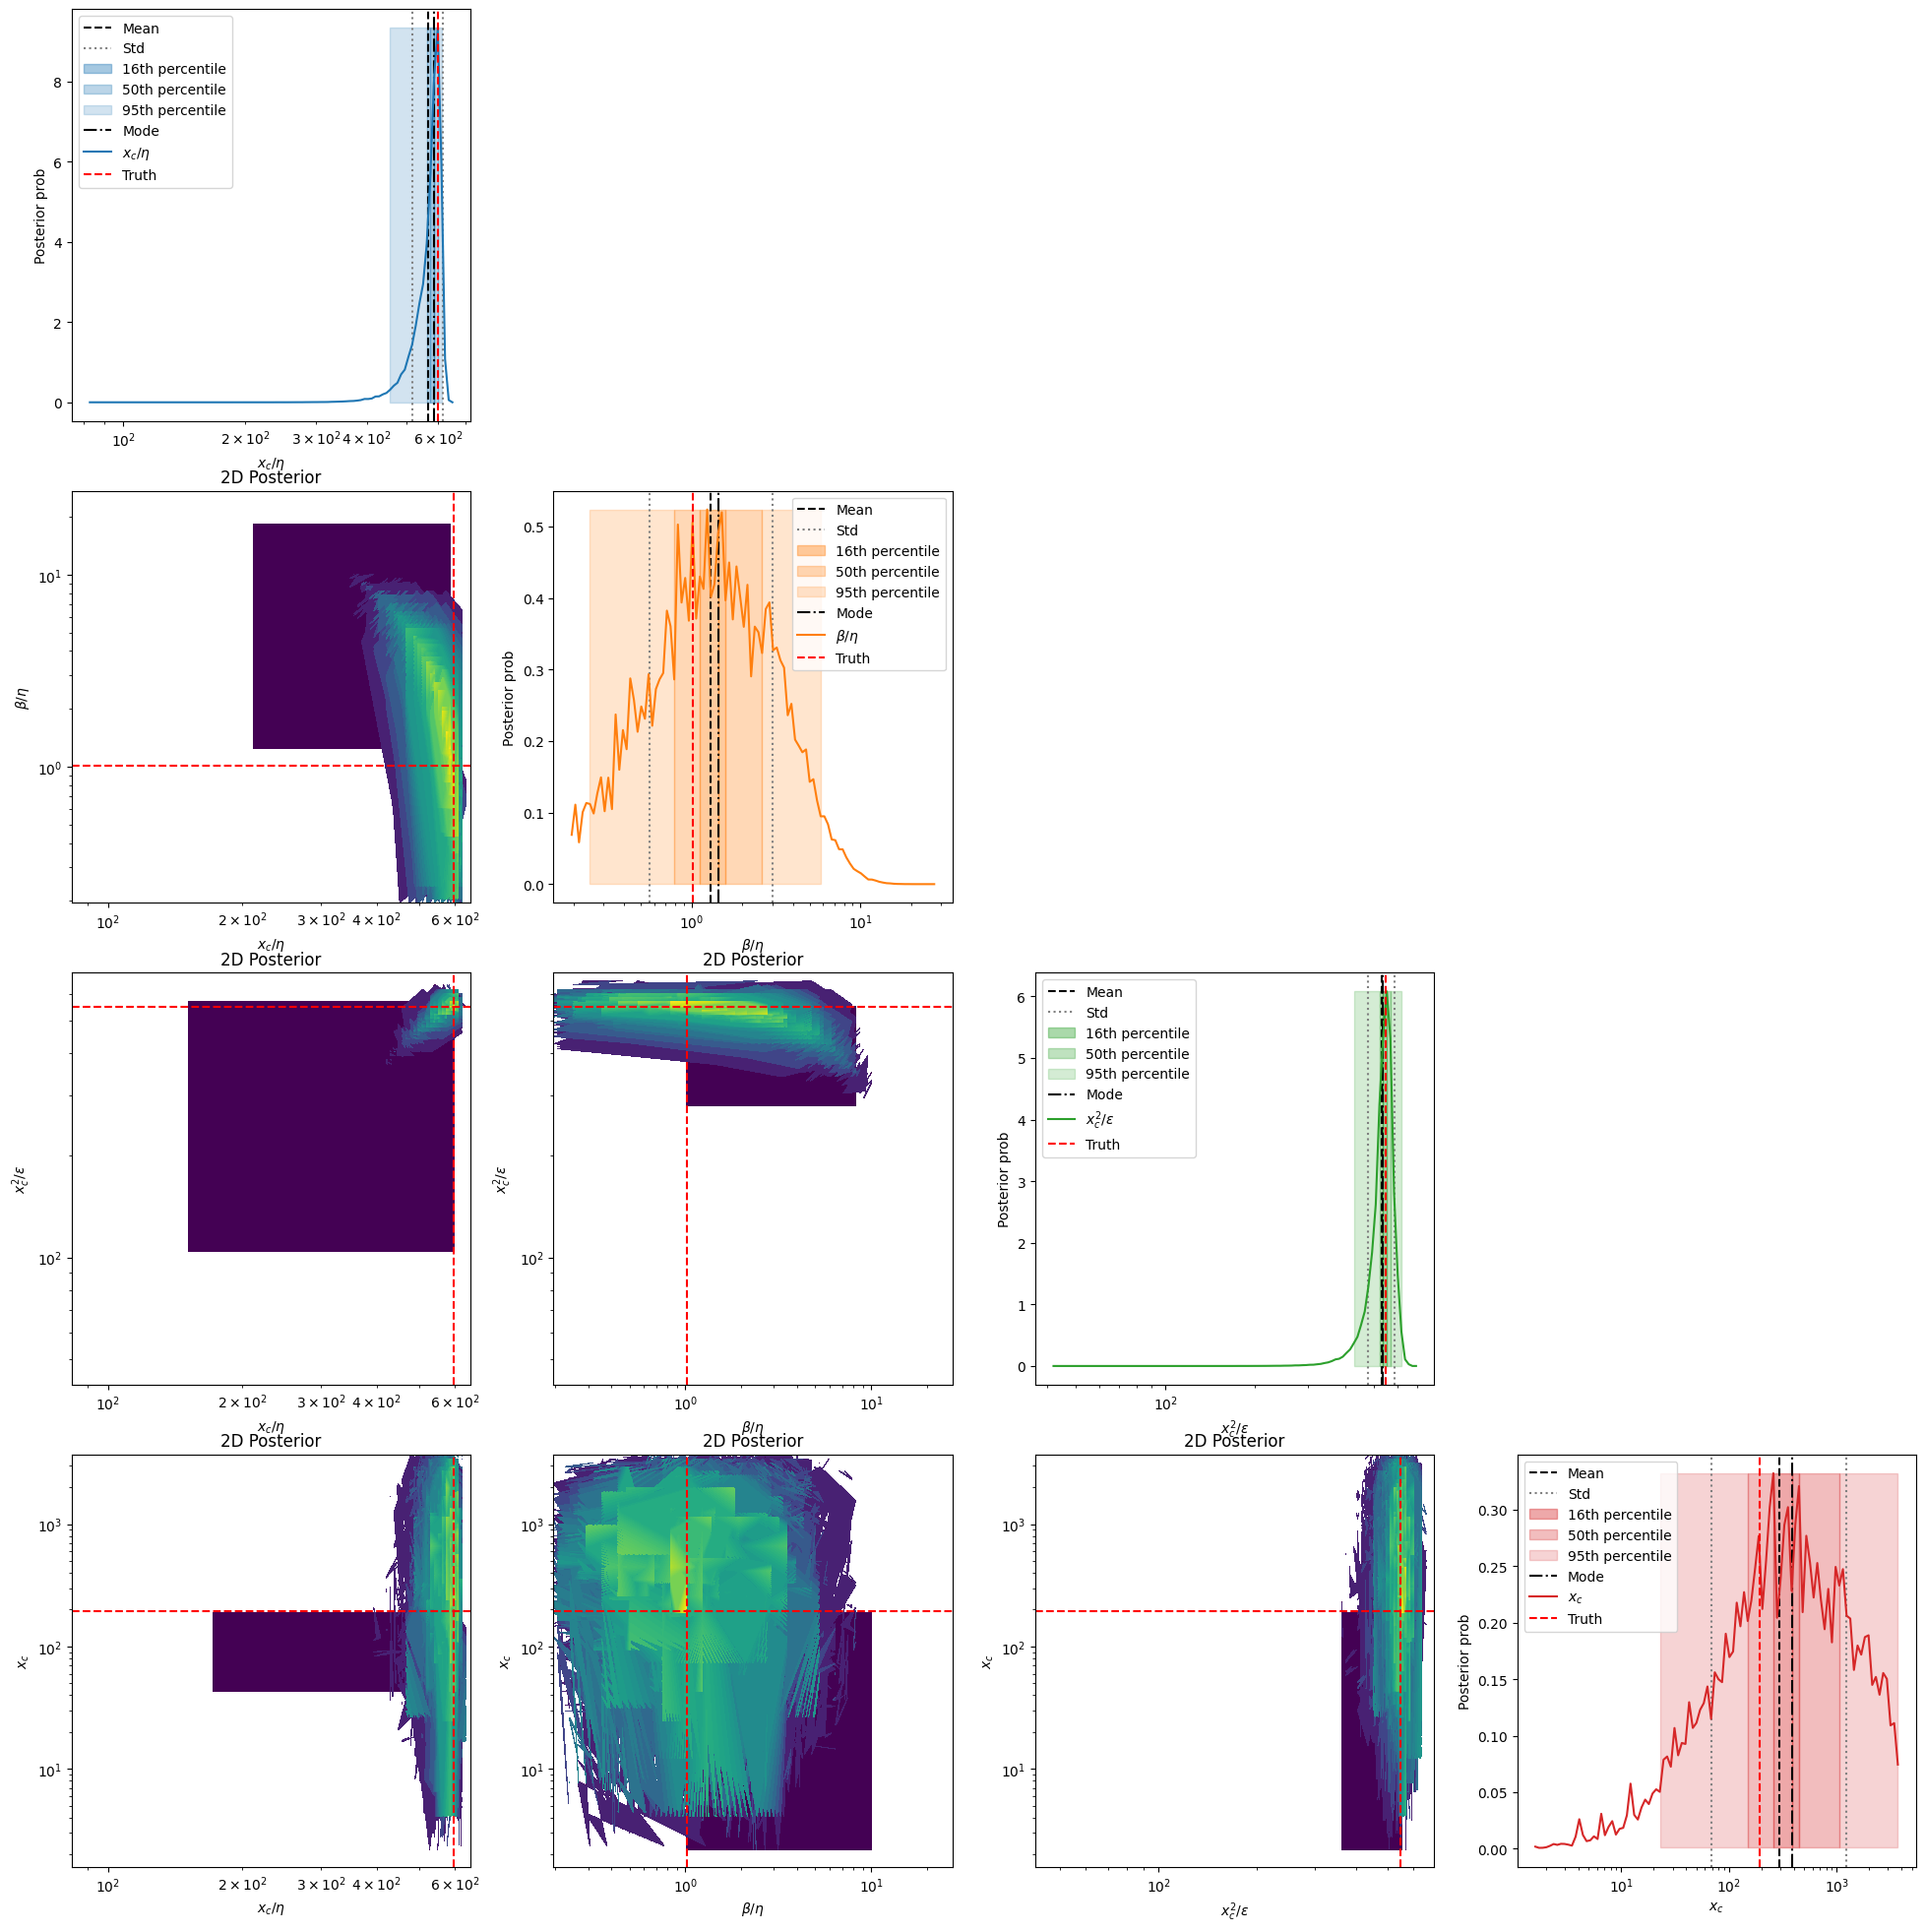

In [15]:
post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False,norm='log')

In [18]:
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])

Averaging log-probabilities: 100%|██████████| 36707/36707 [00:00<00:00, 248852.91it/s]


In [17]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,565.369,"[50.795, 46.608]",598.15,"[598.15, 598.15]","[573.761, 610.73]","[475.747, 623.575]",597.457
beta/eta,1.304,"[1.712, 0.74]",1.238,"[1.121, 1.589]","[0.831, 2.751]","[0.239, 5.532]",1.016
xc^2/epsilon,530.425,"[57.376, 51.775]",552.736,"[552.736, 552.736]","[522.324, 568.6]","[428.468, 618.975]",547.973
xc,292.927,"[945.104, 223.618]",258.512,"[161.615, 302.329]","[118.164, 836.52]","[22.829, 3702.292]",194.575
eta,0.277,"[1.47, 0.233]",0.806,"[0.467, 1.059]","[0.156, 2.404]","[0.0111, 6.548]",0.326
beta,0.249,"[1.628, 0.216]",0.288,"[0.221, 0.492]","[0.0756, 1.255]","[0.0068, 15.946]",0.331
epsilon,45.931,"[1758.906, 44.762]",415.421,"[87.434, 415.421]","[15.477, 3318.166]","[0.0722, 26503.768]",69.09
sqrt(eta/xc},23.725,"[1.054, 1.009]",24.457,"[24.457, 24.457]","[23.953, 24.713]","[21.812, 24.971]",24.443
s= eta^0.5*xc^1.5/epsilon,22.205,"[1.555, 1.454]",22.723,"[22.306, 22.723]","[21.897, 23.147]","[19.237, 24.925]",22.418
beta*xc/epsilon,1.296,"[1.655, 0.727]",1.388,"[1.201, 1.684]","[0.777, 2.48]","[0.256, 5.641]",0.931


In [33]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'
theta_mode =  df.loc[['eta','beta','epsilon','xc'],'mode'].values
print(f"theta_mode: {theta_mode}")
theta_mode_trans = df.loc[['xc/eta','beta/eta','xc^2/epsilon','xc'],'mode'].values
print(f"theta_mode_trans: {theta_mode_trans}")
sim_mode = srmc.getSr(theta_mode, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)
sim_mode_trans = srmc.getSr(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)


theta_mode: [0.806 0.288 415.421 258.512]
theta_mode_trans: [598.15 1.238 552.736 258.512]


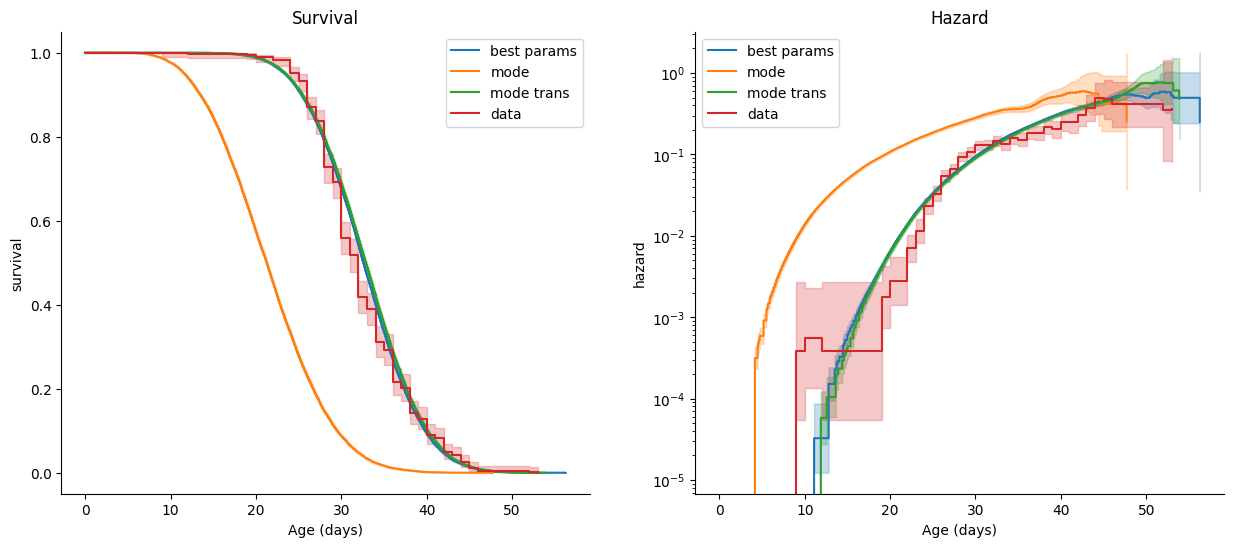

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0], label='best params', title='Survival', xlabel='time [years]', ylabel='survival')
sim_mode.plotSurvival(ax=ax0, label='mode')
sim_mode_trans.plotSurvival(ax=ax0, label='mode trans')
ds.plotSurvival(ax=ax0, label='data')

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params')
sim_mode.plotHazard(ax=ax1, label='mode')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

Averaging log-probabilities: 100%|██████████| 17252/17252 [00:00<00:00, 383472.62it/s]


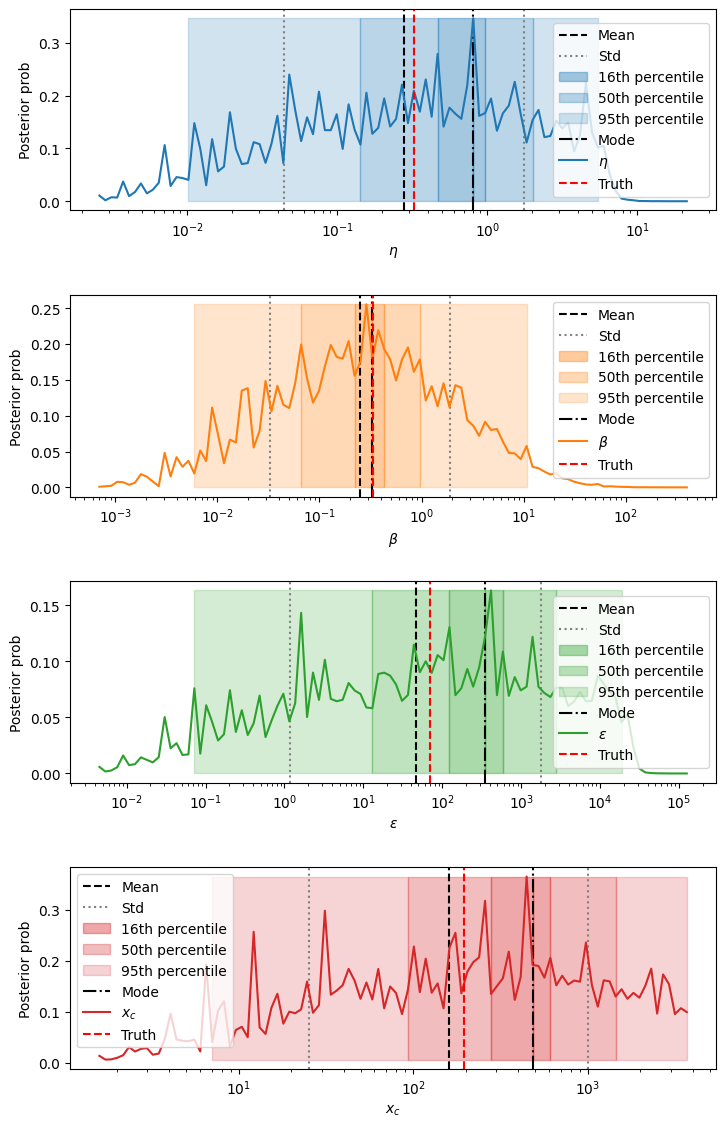

In [12]:
import samples_utils as su
post_regular_params = su.Posterior(samples, lnprobs, 100, log=True)
post_regular_params.plot_1d_posteriors(labels=["$\\eta$","$\\beta$","$\\epsilon$","$x_c$"], truths=sorted_samples[-1],scale='log')